# Caso de Negocio

### Puntaje de Valor del Cliente



En un entorno competitivo, las empresas buscan no solo adquirir nuevos clientes, sino también retener a los existentes y maximizar el valor que cada cliente aporta a lo largo de su vida. La personalización y la segmentación de clientes se han vuelto esenciales para aumentar la efectividad de las campañas de marketing.

Oportunidad: La empresa con la que trabajamos actualmente tiene datos valiosos sobre sus clientes, pero no los estan utilizando de manera efectiva para clasificar y predecir el comportamiento futuro. Implementar un sistema de puntaje puede ayudar a la empresa a identificar a los clientes más valiosos y aquellos que necesitan atención.

### Preparación del ambiente

In [ ]:
#!pip install shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
df = pd.read_csv('data/sales-transactions.csv', encoding='latin-1')

df['Fecha'] = pd.to_datetime(df['Fecha'])

# Selección de Variables

## Variable Objetivo:

La variable objetivo será el Puntaje Total del Cliente, que se calcula en función de múltiples métricas relacionadas con el comportamiento de compra y la lealtad del cliente.

Las métricas que se utilizarán para calcular el puntaje incluyen:

- **Frecuencia de Compra:** Número de transacciones realizadas por el cliente.
- **Gasto Total:** Total gastado por el cliente en un período determinado.
- **Antigüedad del Cliente:** Tiempo que el cliente ha estado activo (en días).

## Variables Independientes

* **No. de Hijos:** Afecta el consumo y las necesidades de compra.
* **Antigüedad:** Indica lealtad y comportamiento a largo plazo, útil para predecir valor futuro.
* **Edad:** Diferentes grupos de edad tienen patrones de compra distintos.
* **Estado Civil:** Influye en el comportamiento de compra según las responsabilidades familiares.
* **Estado:** La ubicación afecta el acceso a productos y patrones de compra.
* **Sexo:** Impacta en preferencias y patrones de consumo.
* **Grupo:** Segmenta a los clientes por comportamiento, ayudando en la predicción de valor.
* **Importe Promedio:** Refleja el gasto típico, para identificar clientes de alto valor.
* **Cantidad Promedio:** Indica el volumen de compras.

# Selección de Datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
df = pd.read_csv('data/sales-transactions.csv', encoding='latin-1')

df['Fecha'] = pd.to_datetime(df['Fecha'])

In [3]:
df_1 = df.groupby(['Clave_Cliente','Transaccion']).agg({
    'Importe': 'sum',  # Valor total gastado por cliente hasta la fecha
    'Cantidad':'sum'
}).reset_index().groupby('Clave_Cliente').agg({
        'Transaccion':'count',
        'Importe': 'sum',
        'Cantidad': 'sum'
    }).reset_index().assign(importe_promedio = lambda x: x['Importe']/x['Transaccion'],
                            cantidad_promedio = lambda x: x['Cantidad']/x['Transaccion'])

df_2 = df.groupby('Clave_Cliente').agg(
    Fecha_Min=('Fecha', 'min'),
    Fecha_Max=('Fecha', 'max')
).reset_index().assign(dias = lambda x:  (x['Fecha_Max']-x['Fecha_Min']).dt.days+1)

df_merged = df_1.merge(df_2,how='inner',on='Clave_Cliente')

In [4]:
#Normalizar los datos
minmaxscaler = MinMaxScaler(feature_range=(0,100))

scaled_values = minmaxscaler.fit_transform(df_merged[['Transaccion','Importe','dias']].values)
scaled_df = pd.DataFrame(scaled_values, columns=['transaccion','importe','dias'])
scaled_df = scaled_df.assign(puntaje = lambda x: x['transaccion']*0.30 + x['importe']*0.60+x['dias']*0.10)

In [5]:
df_premodel = df[['Clave_Cliente','No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo']].drop_duplicates()

df_premodel = df_premodel.merge(df_merged, on='Clave_Cliente',how='inner')

In [6]:
df_premodel = df_premodel[['No._Hijos','Antiguedad','Edad','Estado_Civil','Estado','Sexo','Grupo','importe_promedio','cantidad_promedio']]

df_premodel['puntaje'] = scaled_df['puntaje'].values

In [7]:
#Codificar datos categóricos
lbl_encoder = LabelEncoder()

df_model = df_premodel.copy().reset_index(drop=True)
df_model['Estado_Civil'] = lbl_encoder.fit_transform(df_model['Estado_Civil'])
df_model['Estado'] = lbl_encoder.fit_transform(df_model['Estado'])
df_model['Sexo'] = lbl_encoder.fit_transform(df_model['Sexo'])
df_model['Grupo'] = lbl_encoder.fit_transform(df_model['Grupo'])

# EDA

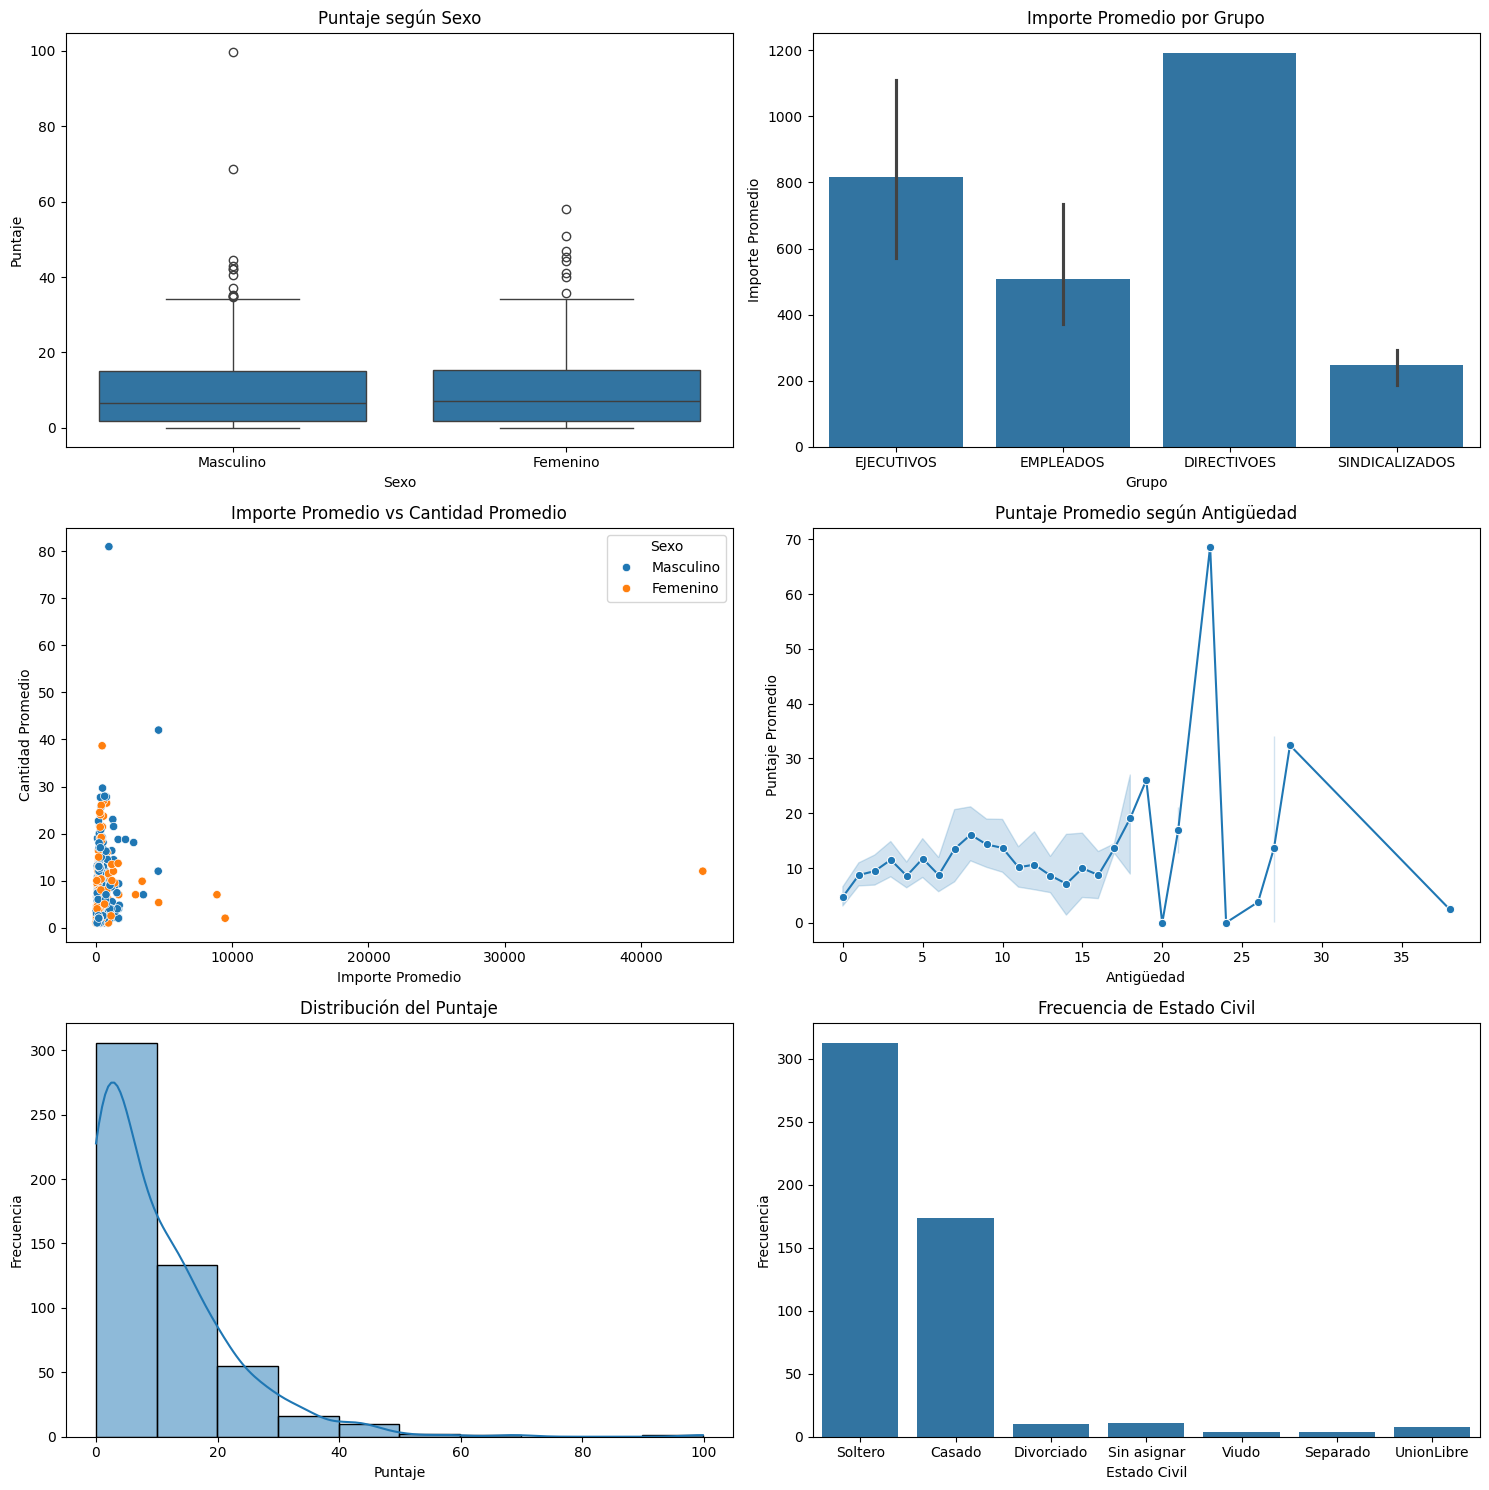

In [8]:
# Crear subplots para gráficas relevantes
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Gráfico de Cajas - Puntaje según Sexo
sns.boxplot(x='Sexo', y='puntaje', data=df_premodel, ax=axs[0, 0])
axs[0, 0].set_title("Puntaje según Sexo")
axs[0, 0].set_xlabel("Sexo")
axs[0, 0].set_ylabel("Puntaje")

# Gráfico de Barras - Importe Promedio por Grupo
sns.barplot(x='Grupo', y='importe_promedio', data=df_premodel, ax=axs[0, 1])
axs[0, 1].set_title("Importe Promedio por Grupo")
axs[0, 1].set_xlabel("Grupo")
axs[0, 1].set_ylabel("Importe Promedio")

# Gráfico de Dispersión - Importe Promedio vs Cantidad Promedio
sns.scatterplot(x='importe_promedio', y='cantidad_promedio', hue='Sexo', data=df_premodel, ax=axs[1, 0])
axs[1, 0].set_title("Importe Promedio vs Cantidad Promedio")
axs[1, 0].set_xlabel("Importe Promedio")
axs[1, 0].set_ylabel("Cantidad Promedio")

# Gráfico de Línea - Puntaje promedio según Antigüedad
sns.lineplot(x='Antiguedad', y='puntaje', estimator='mean', data=df_premodel, ax=axs[1, 1], marker="o")
axs[1, 1].set_title("Puntaje Promedio según Antigüedad")
axs[1, 1].set_xlabel("Antigüedad")
axs[1, 1].set_ylabel("Puntaje Promedio")

# Gráfico de Distribución - Puntaje
sns.histplot(df_premodel['puntaje'], bins=10, kde=True, ax=axs[2, 0])
axs[2, 0].set_title("Distribución del Puntaje")
axs[2, 0].set_xlabel("Puntaje")
axs[2, 0].set_ylabel("Frecuencia")

# Gráfico de Barras - Frecuencia de Estado Civil
sns.countplot(x='Estado_Civil', data=df_premodel, ax=axs[2, 1])
axs[2, 1].set_title("Frecuencia de Estado Civil")
axs[2, 1].set_xlabel("Estado Civil")
axs[2, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


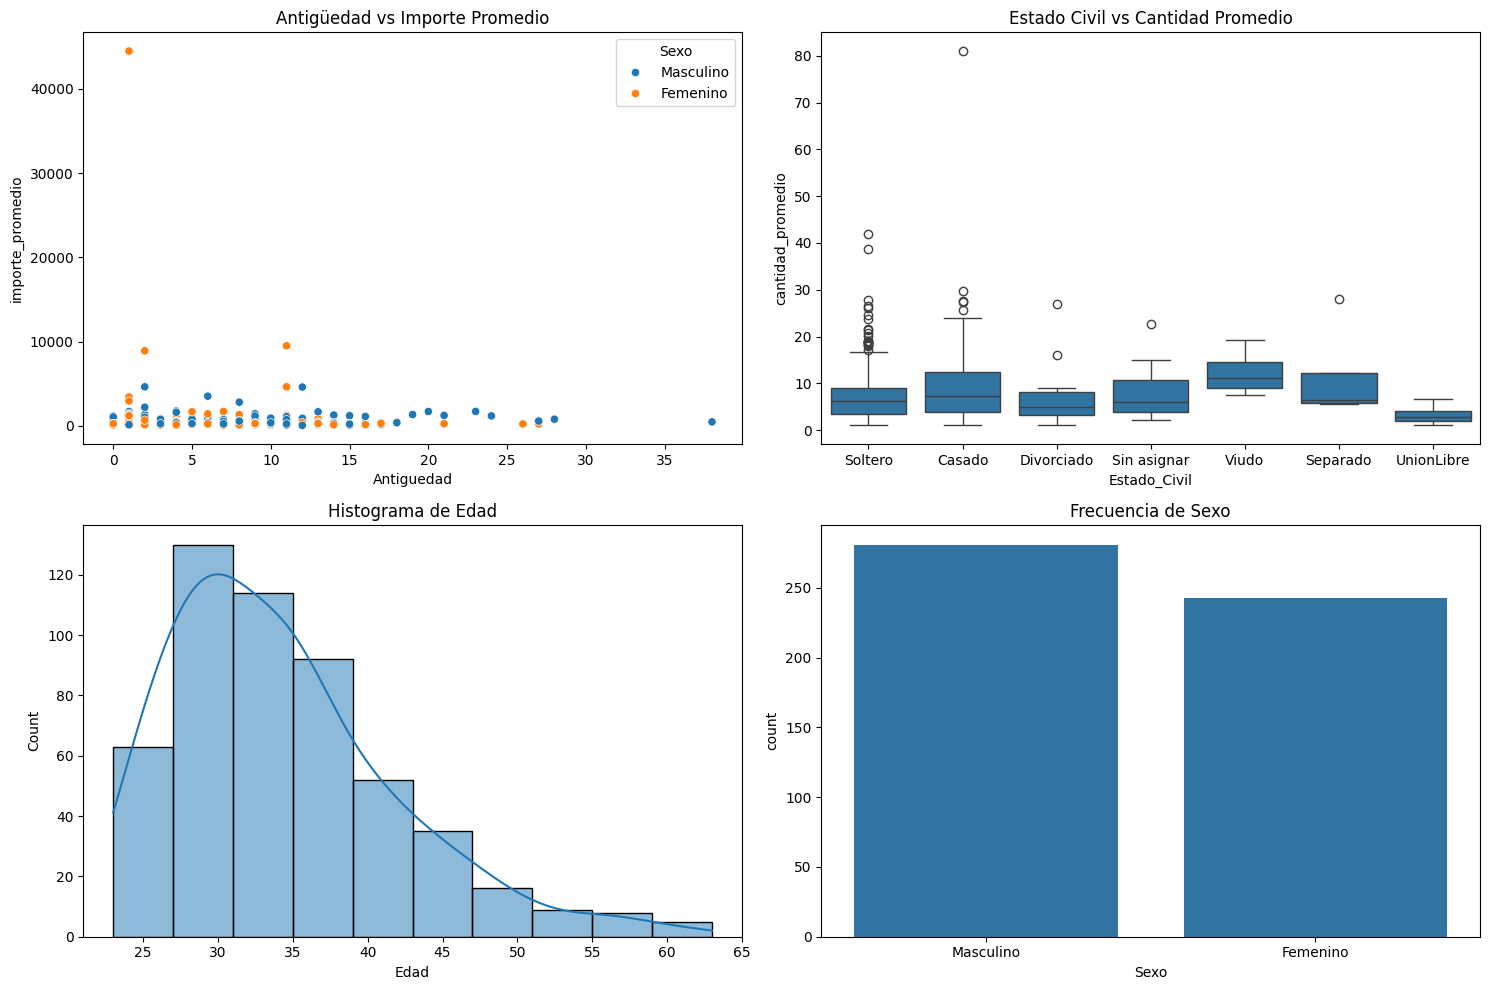

In [9]:
# Crear subplots para varias gráficas de EDA
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico de Dispersión - Antigüedad vs Importe Promedio
sns.scatterplot(x='Antiguedad', y='importe_promedio', hue='Sexo', data=df_premodel, ax=axs[0, 0])
axs[0, 0].set_title("Antigüedad vs Importe Promedio")

# Gráfico de Cajas - Estado Civil vs Cantidad Promedio
sns.boxplot(x='Estado_Civil', y='cantidad_promedio', data=df_premodel, ax=axs[0, 1])
axs[0, 1].set_title("Estado Civil vs Cantidad Promedio")

# Histograma - Edad
sns.histplot(df_premodel['Edad'], bins=10, kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Histograma de Edad")

# Gráfico de Barras - Frecuencia de Sexo
sns.countplot(x='Sexo', data=df_premodel, ax=axs[1, 1])
axs[1, 1].set_title("Frecuencia de Sexo")

plt.tight_layout()
plt.show()

In [11]:
df_premodel.head()

,No._Hijos,Antiguedad,Edad,Estado_Civil,Estado,Sexo,Grupo,importe_promedio,cantidad_promedio,puntaje
0,0,11,35,Soltero,Nuevo Leon,Masculino,EJECUTIVOS,475.500000,13.250000,18.327738
1,0,15,41,Soltero,Nuevo Leon,Femenino,EMPLEADOS,261.069592,8.448980,17.750406
2,0,3,34,Soltero,Nuevo Leon,Femenino,EMPLEADOS,225.212500,7.250000,2.216405
3,0,38,63,Casado,Nuevo Leon,Masculino,EJECUTIVOS,453.916800,12.000000,2.482581
4,0,13,39,Soltero,Nuevo Leon,Femenino,EMPLEADOS,434.781852,18.537037,19.708960


# Modelos de Regresión

In [12]:
#Split de datos
x_train, x_test, y_train, y_test =  train_test_split(df_model.drop(columns='puntaje'),df_model['puntaje'],test_size=0.3)

### Functions
Se crean funciones que se utilizarán en otras secciones del código

In [14]:
def plot_importance_feature(model):
    plt.figure(figsize=(10, 3))
    bars = plt.bar(model.feature_names_in_, model.feature_importances_)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=20)
    plt.show()

In [15]:
list_metrics = []
def save_metrics(model, y_test,predictions):
    rmse = root_mean_squared_error(y_test,predictions)
    r2 = r2_score(y_test,predictions)

    list_metrics.append([model.__class__.__name__,rmse,r2])

In [16]:
def plot_histograms(top_4_features):
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))

    for i, variable in enumerate(top_4_features.items()):
        ax1 = axs[i, 0]  # Subplot para la primera fila
        ax2 = axs[i, 1]  # Subplot para la segunda fila

        # Histograma superior
        x_train[variable[0]].hist(range=np.percentile(x_train[variable[0]], q=(5, 95)), bins=12, color='skyblue', edgecolor='black', ax=ax1)
        ax1.set_title(f'{variable[0]} - Importance: {variable[1]:.2f}')
        ax1.set_xlabel(variable[0])
        ax1.set_ylabel('Frecuencia')

        # Histograma inferior (puedes ajustar los datos o modificarlo según sea necesario)
        x_test[variable[0]].hist(range=np.percentile(x_test[variable[0]], q=(5, 95)), bins=12, color='lightcoral', edgecolor='black', ax=ax2)
        ax2.set_title(f'{variable[0]} - Importance: {variable[1]:.2f}')
        ax2.set_xlabel(variable[0])
        ax2.set_ylabel('Frecuencia')

    plt.tight_layout()  # Ajustar el espacio entre subplots
    plt.show()

In [17]:
def scatter_plot(predictions, model):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, predictions, color='blue', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
    plt.title(f'Scatter Plot - {model.__class__.__name__}')
    plt.xlabel('True Values')
    plt.ylabel('Predict Values')
    plt.grid(True)
    plt.show()

In [18]:
def residual_plot(predictions, model):
    residuos = [real - pred for real, pred in zip(y_test, predictions)]

    plt.figure(figsize=(8, 4))
    plt.scatter(predictions, residuos, color='blue', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')  # Línea en y=0
    plt.title(f'Residual plot  - {model.__class__.__name__}')
    plt.xlabel('Predict Values')
    plt.ylabel('Scraps')
    plt.grid(True)
    plt.show()

## Modelo 1: Regresión de Árboles de Decisión

In [19]:
regressor_1 = DecisionTreeRegressor(criterion='friedman_mse')

regressor_1.fit(x_train, y_train)
predictions_1 = regressor_1.predict(x_test)

importances = regressor_1.feature_importances_

feature_importance = dict(zip(regressor_1.feature_names_in_, importances))
top_4_features_1 = dict(sorted(feature_importance.items(), key = lambda item: item[1], reverse=True)[:4])

save_metrics(regressor_1, y_test, predictions_1)

### Impacto de Variables

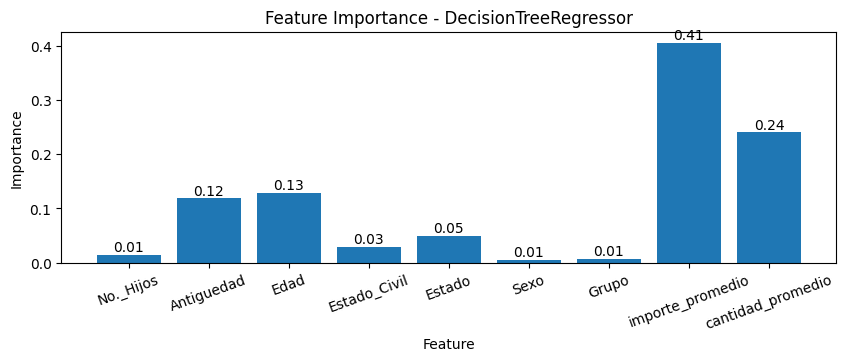

In [20]:
plot_importance_feature(regressor_1)

### Histograma de las variables de impacto

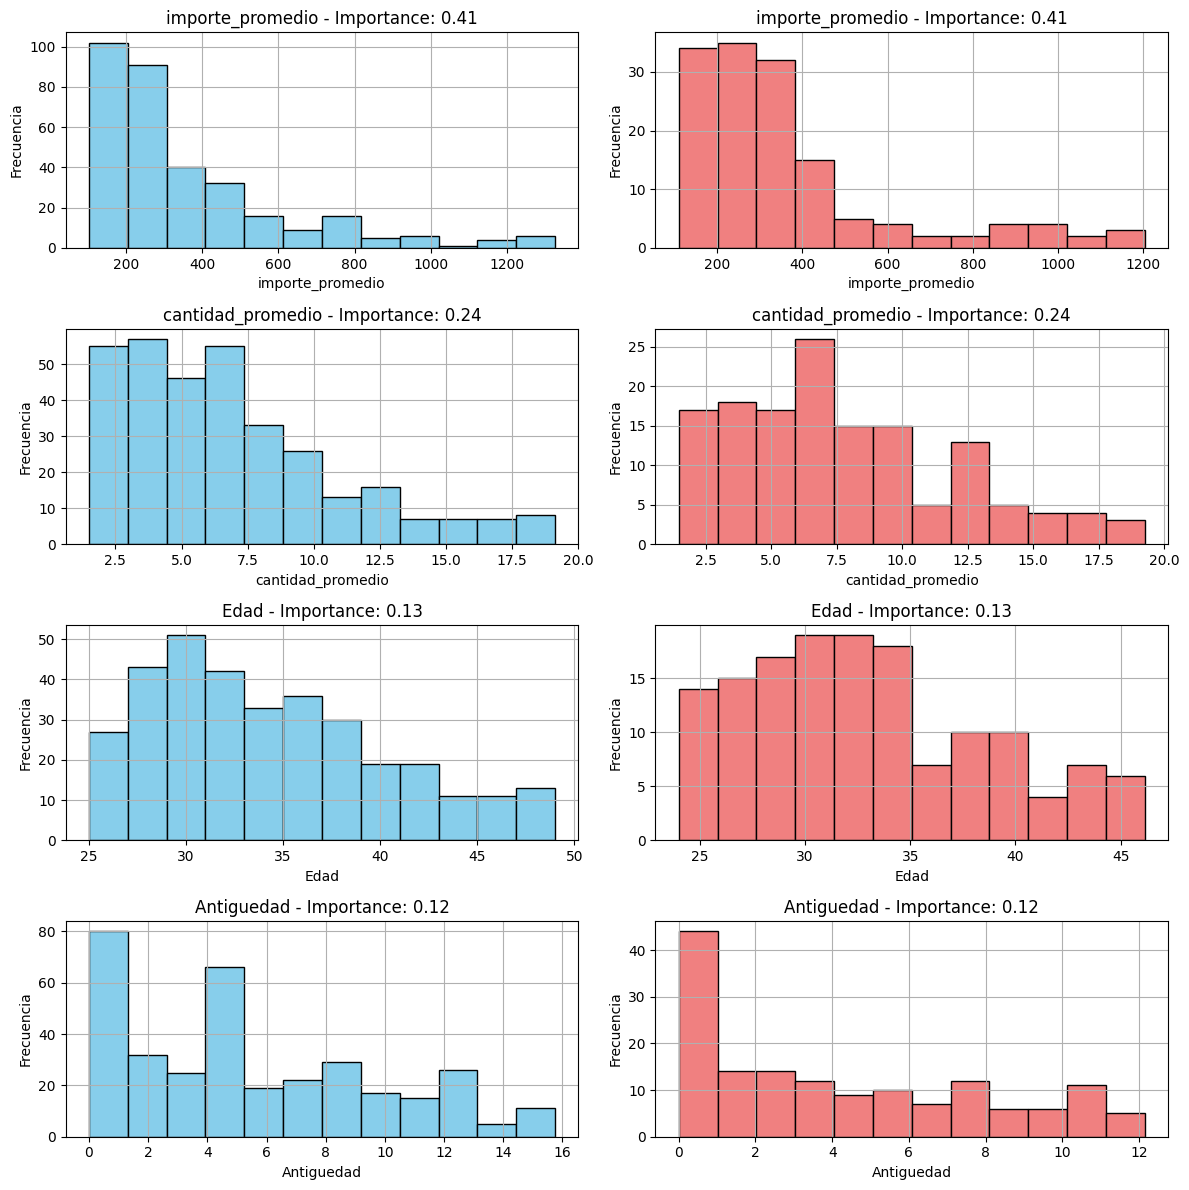

In [21]:
plot_histograms(top_4_features_1)

Al tener las graficas que nos indican que variables son las más importantes nos podemos enfocar en ellas y de los histogramas que nos indican las frecuencias que impactan en el consumo y tiempo activo del cliente en la sucursal, dándole importancia a clientes que han hechos compras con gastos pequeños (importes de entre 200 y 400 y cantidades promedios de entre 2.5 y 7.5 ) y que tienen una antigüedad no mayor a 2, por lo tanto sus mayor tasa de clientes son consumidores esporádicos de pocos productos y de bajo costos, además de no llevar tanto tiempo afiliado a la sucursal

### SHAP Plot
Muestra el comportamiento de los valores y la importancia de las variables en el modelo de regresión aplicado, mientras más a la derecha este el valor, más peso tendra en la predicción, todo lo contrario si está a la izquierda que la disminuye. Si el valor es roja es un valor alto si es azul es un valor bajo. (No se sabe que tan alto o bajos son los valores)

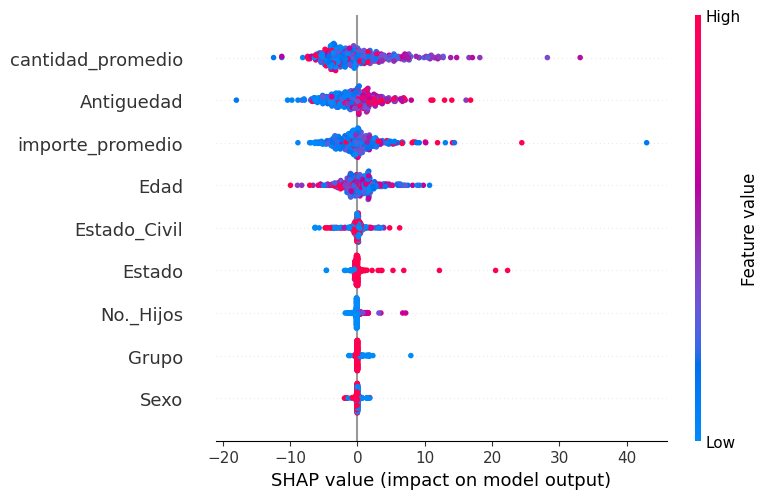

In [22]:
explainer = shap.Explainer(regressor_1)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, x_train)

### Evaluación de Modelo 1:

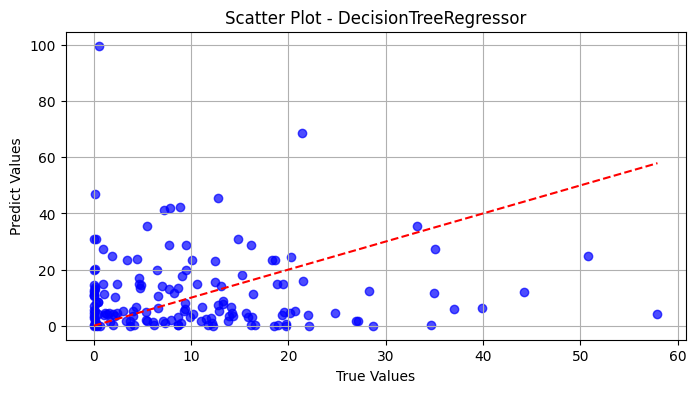

In [23]:
scatter_plot(predictions_1,regressor_1)

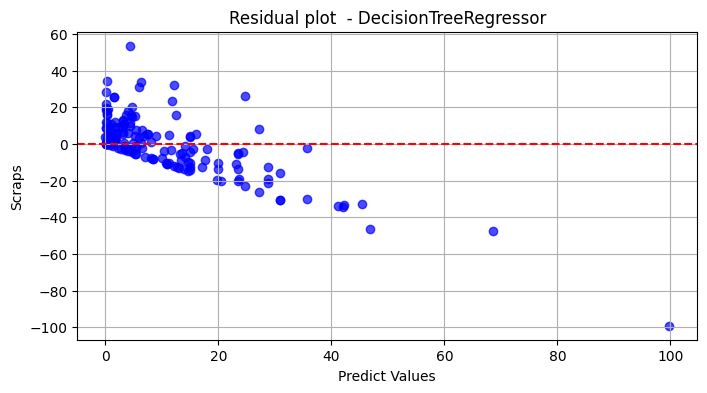

In [24]:
residual_plot(predictions_1, regressor_1)

## Modelo 2: GradientBoostingRegressor

In [25]:
regressor_2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
regressor_2.fit(x_train, y_train)
predictions_2 = regressor_2.predict(x_test)

importances2 = regressor_2.feature_importances_

feature_importance = dict(zip(regressor_2.feature_names_in_, importances2))
top_4_features_2 = dict(sorted(feature_importance.items(), key = lambda item: item[1], reverse=True)[:4])

save_metrics(regressor_2, y_test, predictions_2)

### Impacto de Variables

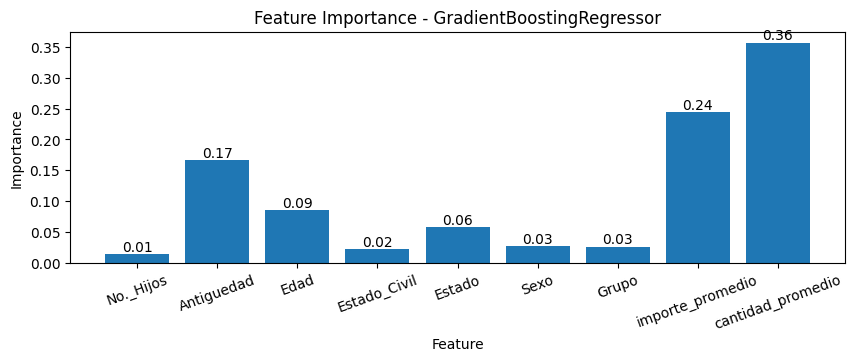

In [26]:
plot_importance_feature(regressor_2)

### Histograma de las variables de impacto

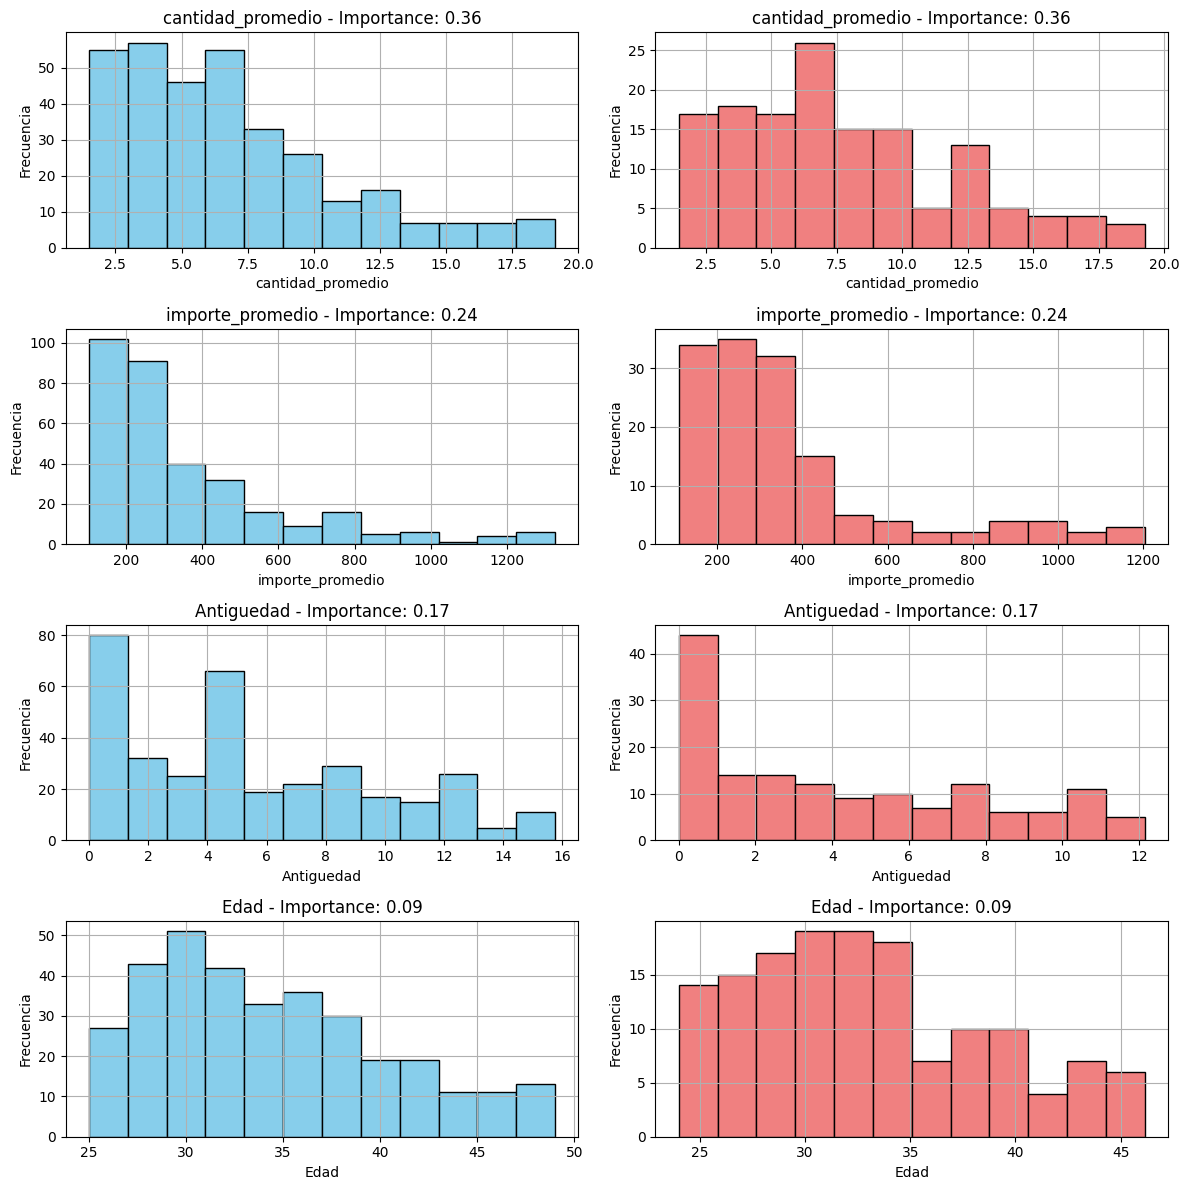

In [27]:
plot_histograms(top_4_features_2)

Al tener las graficas que nos indican que variables son las más importantes nos podemos enfocar en ellas y de los histogramas que nos indican las frecuencias que impactan en el consumo y tiempo activo del cliente en la sucursal, dándole importancia a clientes que han hechos compras con gastos pequeños (importes de entre 200 y 400 y cantidades promedios de entre 2.5 y 7.5 ) y que tienen una antigüedad no mayor a 2, por lo tanto sus mayor tasa de clientes son consumidores esporádicos de pocos productos y de bajo costos, además de no llevar tanto tiempo afiliado a la sucursal

### SHAP Plot

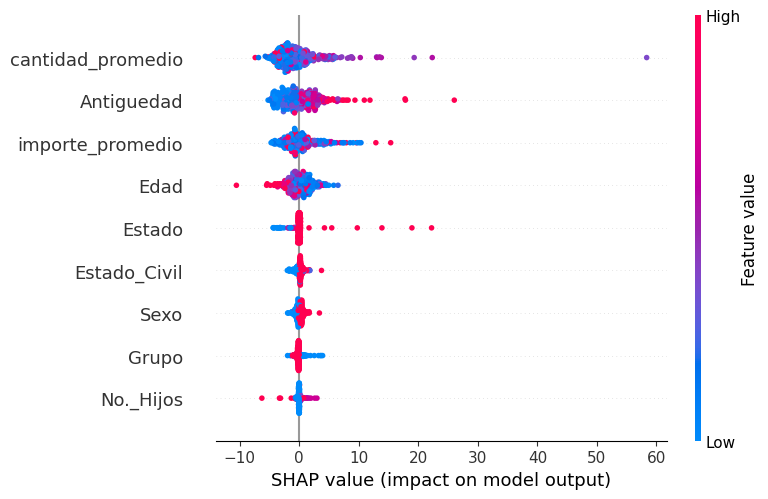

In [28]:
# Crear el explainer para Gradient Boosting
explainer2 = shap.Explainer(regressor_2)
# Obtener los valores SHAP para el conjunto de entrenamiento
shap_values = explainer2(x_train)

# Gráfico resumen de SHAP
shap.summary_plot(shap_values, x_train)

### Evaluación de Modelo 2

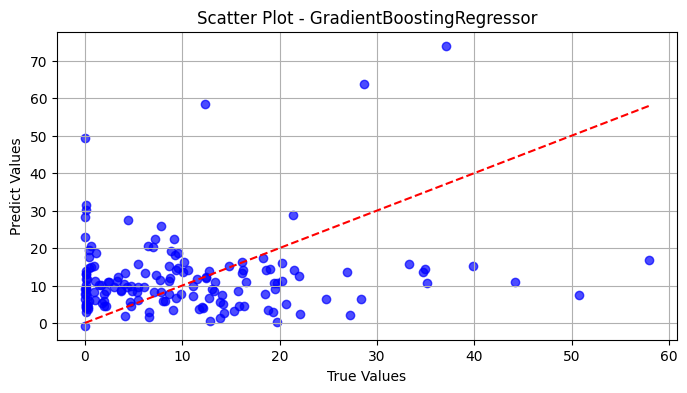

In [29]:
scatter_plot(predictions_2,regressor_2)

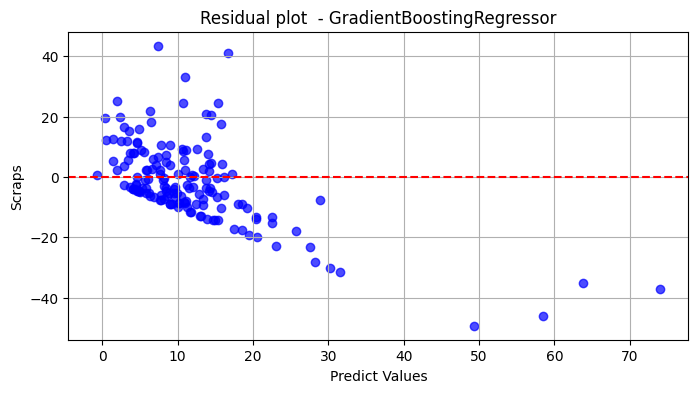

In [30]:
residual_plot(predictions_2, regressor_2)

# Conclusiones

Vemos que `GradientBoostingRegressor` nos da mejores resultados comparados a `DecisionTreeRegressor`, no usamos modelos de regresión lineal, polinómica, ridge, lasso, debido a que la naturaleza de los datos como se ven en las `gráficas de dispersión`, no se ajustan a una recta ya sea lineal o polinómica, vemos que nuestro score de clientes va de 0-100 pero obtenemos un `rmse` de `10.893406`, lo cual indica que tenemos un 10% de variación, lo cual es un buen indicador de nuestro modelo.  

Se hizo uso de SHAP para poder hallar la densidad de valores que tenian una fuerte influencia en los modelos, obteniendo que en ambos casos el `importe_promedio` y la `cantida_promedio` son las variables que más afectaron a nuestros modelos y el SHAP indica que los valores prediominantes eran bajos, más no nos indica el o los valores como tal, solo que son bajos (azules)

In [31]:
pd.DataFrame(list_metrics,columns=['model_name','root_mean_square_error','r2'])

,model_name,root_mean_square_error,r2
0,DecisionTreeRegressor,17.156646,-1.586132
1,GradientBoostingRegressor,13.713849,-0.652360
